In [1]:
import pandas as pd

### 데이터 로드 및 확인

In [18]:
df = pd.read_csv('data-files\소방청_구조활동현황.csv', encoding='cp949')

print("="*50)
display(df.head())

print("="*50)
display(df.info())

,번호,신고년월일,신고시각,출동년월일,출동시각,발생장소_시,발생장소_구,발생장소_동,사고원인,사고원인코드명_사고종별
0,1,2023-01-01,00:00,2023-01-01,00:01,경기도,김포시,월곶면,화재,자동차·철도차량
1,2,2023-01-01,00:00,2023-01-01,00:01,경기도,김포시,월곶면,화재,자동차·철도차량
2,3,2023-01-01,00:01,2023-01-01,00:03,충청남도,천안시 동남구,신부동,잠금장치개방,출입문
3,4,2023-01-01,00:03,2023-01-01,00:04,서울특별시,중구,충무로2가,화재,건축·구조물
4,5,2023-01-01,00:04,2023-01-01,00:05,제주특별자치도,제주시,이도이동,비화재보 확인,자동화재탐지설비


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651137 entries, 0 to 651136
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   번호            651137 non-null  int64 
 1   신고년월일         651137 non-null  object
 2   신고시각          651137 non-null  object
 3   출동년월일         651137 non-null  object
 4   출동시각          651137 non-null  object
 5   발생장소_시        651105 non-null  object
 6   발생장소_구        651105 non-null  object
 7   발생장소_동        647090 non-null  object
 8   사고원인          651137 non-null  object
 9   사고원인코드명_사고종별  651137 non-null  object
dtypes: int64(1), object(9)
memory usage: 49.7+ MB


None

### 시계열 데이터 전처리

In [19]:
df['신고일시'] = df['신고년월일'] + " " + df['신고시각']
df['출동일시'] = df['출동년월일'] + " " + df['출동시각']
df['신고일시'] = pd.to_datetime(df['신고일시'])
df['출동일시'] = pd.to_datetime(df['출동일시'])

df.drop(['신고년월일'], axis=1, inplace=True)
df.drop(['신고시각'], axis=1, inplace=True)
df.drop(['출동년월일'], axis=1, inplace=True)
df.drop(['출동시각'], axis=1, inplace=True)

### 상세 확인

In [22]:
# 컬럼별 결측치 확인
df.isnull().sum()

번호                 0
발생장소_시            32
발생장소_구            32
발생장소_동          4047
사고원인               0
사고원인코드명_사고종별       0
신고일시               0
출동일시               0
dtype: int64

In [28]:
# 특정 컬럼의 값 분포 확인
df['발생장소_구'].value_counts()

발생장소_구
서구         12921
화성시        12415
평택시        11809
북구         10216
중구          9674
           ...  
울산광역시          3
광주광역시          2
전북특별자치도        2
대전광역시          1
제주특별자치도        1
Name: count, Length: 242, dtype: int64

### 데이터 그룹화

(1) `groupby` 활용

In [43]:
grouped_df = df.groupby(['발생장소_시', '발생장소_구'])['번호'].count().reset_index().rename(columns={'번호':'사고발생건수'}, inplace=True)

grouped_df

,발생장소_시,발생장소_구,사고발생건수
0,강원특별자치도,강릉시,4897
1,강원특별자치도,강원특별자치도,8
2,강원특별자치도,고성군,1540
3,강원특별자치도,동해시,2144
4,강원특별자치도,삼척시,2525
...,...,...,...
261,충청북도,청주시 서원구,1807
262,충청북도,청주시 청원구,2058
263,충청북도,청주시 흥덕구,2653
264,충청북도,충주시,2690


(2) `pivot_table` 활용

In [53]:
pivot_df = df.pivot_table(
    index=['발생장소_시', '발생장소_구']
    , aggfunc='size'
).reset_index(name='사고발생건수')

pivot_df

,발생장소_시,발생장소_구,사고발생건수
0,강원특별자치도,강릉시,4897
1,강원특별자치도,강원특별자치도,8
2,강원특별자치도,고성군,1540
3,강원특별자치도,동해시,2144
4,강원특별자치도,삼척시,2525
...,...,...,...
261,충청북도,청주시 서원구,1807
262,충청북도,청주시 청원구,2058
263,충청북도,청주시 흥덕구,2653
264,충청북도,충주시,2690


### 시각화

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rc('font', family='Malgun Gothic')

(1) `발생장소_시`별로 `사건발생건수` 시각화

<Axes: xlabel='발생장소_시', ylabel='사고발생건수'>

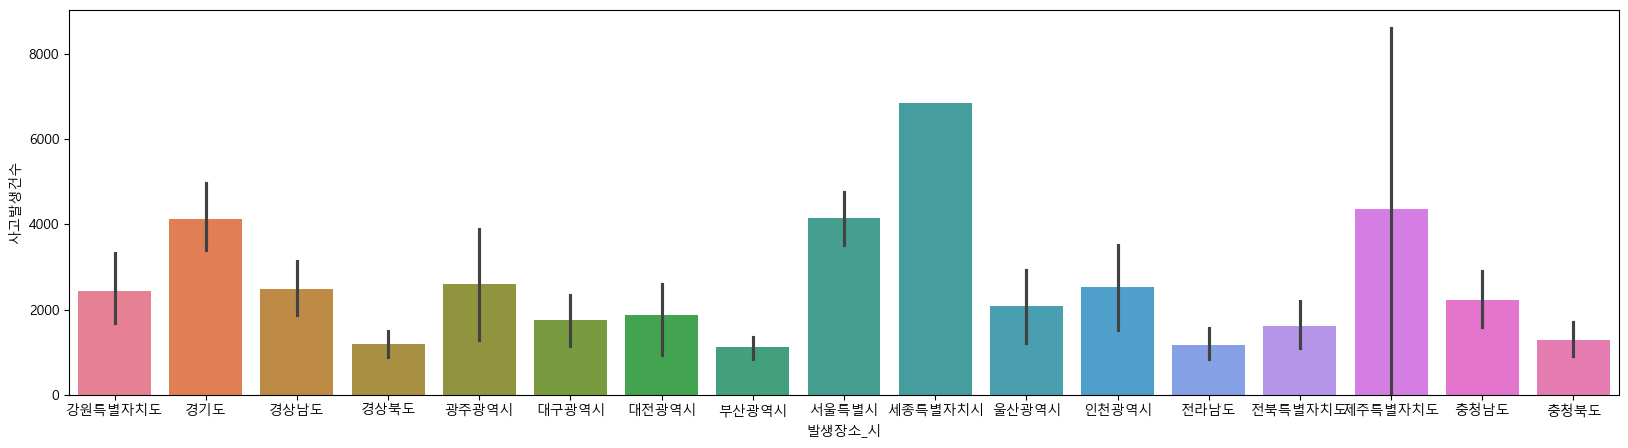

In [76]:
plt.figure(figsize=(20, 5))
sns.barplot(
    data = pivot_df
    , x = '발생장소_시'
    , y = '사고발생건수'
    , hue = '발생장소_시'
)

(2) 서울시의 `발생장소_구`별로 `사건발생건수` 시각화

In [72]:
# 서울시 데이터 추출 및 정리
seoul_pivot_df = pivot_df[pivot_df['발생장소_시']=='서울특별시'].reset_index(drop=True)

# '발생장소_구'가 서울특별시로 되어있는 경우를 제외
to_drop = seoul_pivot_df['발생장소_시'] == seoul_pivot_df['발생장소_구']
seoul_pivot_df = seoul_pivot_df[~to_drop].reset_index(drop=True)
seoul_pivot_df

,발생장소_시,발생장소_구,사고발생건수
0,서울특별시,강남구,8039
1,서울특별시,강동구,4059
2,서울특별시,강북구,4459
3,서울특별시,강서구,6132
4,서울특별시,관악구,4412
5,서울특별시,광진구,3291
6,서울특별시,구로구,3992
7,서울특별시,금천구,3490
8,서울특별시,노원구,4242
9,서울특별시,도봉구,3878


<Axes: xlabel='발생장소_구', ylabel='사고발생건수'>

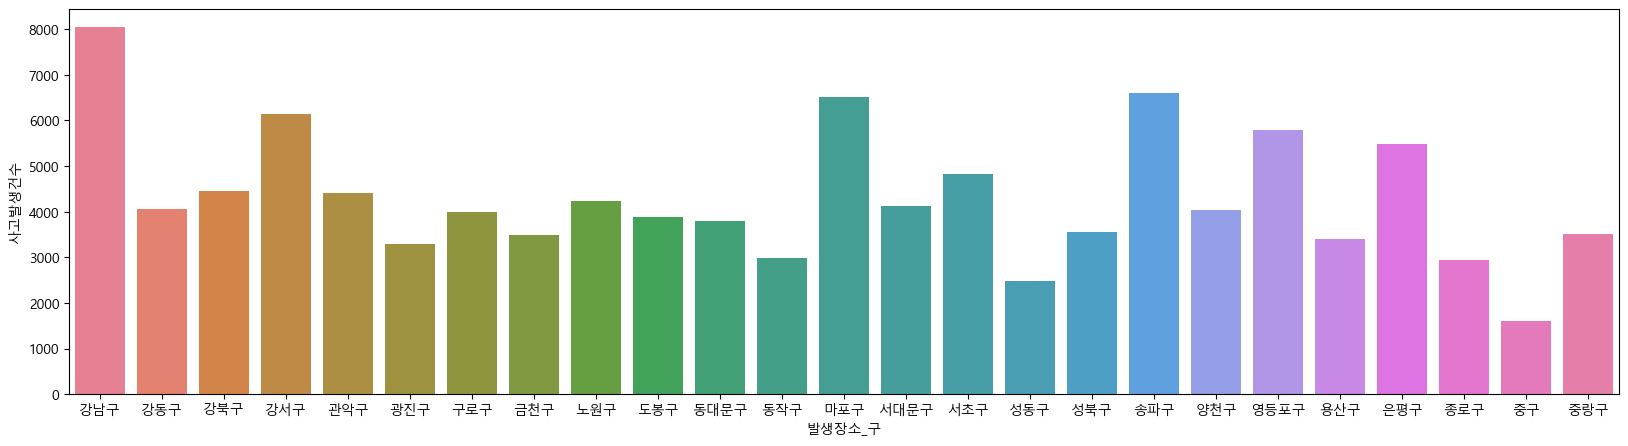

In [75]:
plt.figure(figsize=(20, 5))
sns.barplot(
    data = seoul_pivot_df
    , x = '발생장소_구'
    , y = '사고발생건수'
    , hue = '발생장소_구'
)